In [40]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [46]:
dhs_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_AggregatedFoodGroups_24June2019.csv")

In [47]:
dhs_df.head()

,Cell_Order,fruits,Num_Households_Responded_fruits,vegetables,Num_Households_Responded_vegetables,dairy,Num_Households_Responded_dairy,eggs,Num_Households_Responded_eggs,meat_fish,...,Soil_suit_chocolate,Soil_suit_coffee,Cell_Coord_x,Cell_Coord_y,PerCapita_GDP_2015,PerCapita_GDP_2000,PerCapita_GDP_1990,ISO3C,Continent,World_Region
0,2158169,0.179487,13.0,0.494505,13.0,0.159341,13.0,0.346520,13.0,0.480220,...,0.0,0.0,27.37500,48.375,16748.36,1107.774,5122.521,UKR,Europe,Eastern Europe
1,2158170,0.227965,16.0,0.113839,16.0,0.353051,16.0,0.046875,16.0,0.280072,...,0.0,0.0,27.45833,48.375,36616.53,15197.140,40205.260,MDA,Europe,Eastern Europe
2,2158171,0.166450,11.0,0.282359,11.0,0.319772,11.0,0.106585,11.0,0.136905,...,0.0,0.0,27.54167,48.375,196970.70,1917663.000,NaN,MDA,Europe,Eastern Europe
3,2158173,0.321429,7.0,0.054945,7.0,0.877060,7.0,0.269231,7.0,0.153846,...,0.0,0.0,27.70833,48.375,NaN,NaN,NaN,MDA,Europe,Eastern Europe
4,2158174,0.207953,14.0,0.199923,14.0,0.190168,14.0,0.178890,14.0,0.086466,...,0.0,0.0,27.79167,48.375,NaN,NaN,NaN,MDA,Europe,Eastern Europe


### Preparing Dataset

In [48]:
columns = dhs_df.columns 

desired_food_columns = ["dairy","eggs"
                   ,"meat_fish","nuts_pulses"
                   ,"grains_tubers"]

desired_predictor_columns = ["animal_source_foods"
                   ,"Primary_Religion"
                   ,"Population_2015"
                   ,"Travel_time_to_cities"
                   ,"Soil_suit_overall","Soil_suit_cereals"
                   ,"Soil_suit_pulses","Soil_suit_roots","ISO3C"]


In [49]:
def overview(df):
    print("Datasets shape Rows:{} Columns:{}".format(df.shape[0],df.shape[1]))
    print("----------Number of Missing Values in Each Column------------")
    nan_series = df.isnull().sum(axis = 0)
    print(nan_series)
    print("-------------------------------------------------------------")
    nan_series_trun = df.isnull().sum(axis = 1)
    print("Number of rows with more than 2 missing values:{}".format(nan_series_trun[nan_series_trun > 2].shape))
    # Number of empty data in rows
    print("Number of rows with 0 missing values:{}".format(nan_series_trun[nan_series_trun == 0].shape))
    for i in desired_food_columns:
        nan_series_trun = df[[i] + desired_predictor_columns ].isnull().sum(axis = 1)
        nan_num = nan_series_trun[nan_series_trun == 0].shape
        print("Number of rows with 0 missing values for {}:{}".format(i,nan_num ))

In [50]:
truncated_dhs_df = dhs_df[desired_food_columns+desired_predictor_columns]

In [51]:
# Merging New Dataset on Daily Protein Supply https://ourworldindata.org/food-per-person 

In [52]:
protein_supply_df = pd.read_csv("datasets/daily-per-capita-protein-supply.csv")

In [53]:
protein_supply_df = protein_supply_df[protein_supply_df["Year"] == 2013]

In [54]:
truncated_dhs_protein_df = truncated_dhs_df.merge(protein_supply_df,how="left",left_on="ISO3C",right_on="Code")

In [55]:
overview(truncated_dhs_protein_df)

Datasets shape Rows:33630 Columns:18
----------Number of Missing Values in Each Column------------
dairy                    19400
eggs                     18291
meat_fish                18900
nuts_pulses              18296
grains_tubers            19412
animal_source_foods      18291
Primary_Religion           845
Population_2015          18848
Travel_time_to_cities      709
Soil_suit_overall          687
Soil_suit_cereals          717
Soil_suit_pulses           717
Soil_suit_roots            717
ISO3C                     1064
Entity                    1767
Code                      1767
Year                      1767
 (g/person/day)           1767
dtype: int64
-------------------------------------------------------------
Number of rows with more than 2 missing values:(20594,)
Number of rows with 0 missing values:(5918,)
Number of rows with 0 missing values for dairy:(6213,)
Number of rows with 0 missing values for eggs:(6518,)
Number of rows with 0 missing values for meat_fish:(6317,)

### Machine Learning 

In [61]:
def string_to_int(df, col_name):
    """
    This is a helper function for converting the string labels to numerical
    """
    m = {}
    for i,e in enumerate(df[col_name].unique()):
        m.update({e: i})
    return m

def create_bins_width(df, col_name, bin_width):
    """
    This function cuts bins using equal width method
    """
    max = df[col_name].max()
    min = df[col_name].min()
    bins = np.arange(min, max, bin_width)
    print('This cuts the {} array into {} result in {} bins in equal width'.format(col_name,bins,len(bins)))
    new_col_name = col_name + "_group"
    df[new_col_name] = np.digitize(df[col_name], bins)
    return df


def create_bins_depth(df, col_name, bin_num):
    """
    This function cuts bins using equal depth method
    """
    new_col_name = col_name + " group"
    df[new_col_name],bins= pd.qcut(df[col_name],bin_num, retbins=True, labels=list(range(bin_num)))
    print('This cuts the {} array into {} result in {} bins in equal depth'.format(col_name,bins,bin_num))
    df[new_col_name] = df[new_col_name].astype(int)
    df.drop(col_name, axis=1, inplace=True)


def clean_data(df):
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    m = string_to_int(df, "Primary_Religion")
    df["Primary_Religion"] = df["Primary_Religion"].map(m)
    create_bins_width(df,"Travel_time_to_cities",200)
    create_bins_width(df,"Soil_suit_overall",2)
    for i in desired_food_columns:
        create_bins_width(df,i,0.25)
    df = df.dropna()
    df.to_csv('datasets/cleaned_diet.csv')
    return df


In [62]:
cleaned_dhs_df = clean_data(truncated_dhs_protein_df)
cleaned_dhs_df.head()

This cuts the Travel_time_to_cities array into [   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000. 2200.
 2400. 2600. 2800. 3000. 3200. 3400. 3600. 3800. 4000. 4200. 4400. 4600.] result in 24 bins in equal width
This cuts the Soil_suit_overall array into [0. 2. 4. 6. 8.] result in 5 bins in equal width
This cuts the dairy array into [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75] result in 12 bins in equal width
This cuts the eggs array into [0.   0.25 0.5  0.75] result in 4 bins in equal width
This cuts the meat_fish array into [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75] result in 8 bins in equal width
This cuts the nuts_pulses array into [0.   0.25 0.5  0.75] result in 4 bins in equal width
This cuts the grains_tubers array into [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75] result in 8 bins in equal width


,dairy,eggs,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Primary_Religion,Population_2015,Travel_time_to_cities,Soil_suit_overall,...,Code,Year,(g/person/day),Travel_time_to_cities_group,Soil_suit_overall_group,dairy_group,eggs_group,meat_fish_group,nuts_pulses_group,grains_tubers_group
0,0.159341,0.346520,0.480220,0.159341,0.841392,0.986081,0,92.83489,82.41833,8.561080,...,UKR,2013.0,88.62,1,5,1,2,2,1,4
1,0.353051,0.046875,0.280072,0.074219,0.447915,0.679998,0,1748.38800,74.77269,8.511680,...,MDA,2013.0,71.41,1,5,2,1,2,1,2
2,0.319772,0.106585,0.136905,0.150000,0.609615,0.563262,0,58.91513,96.45230,8.313398,...,MDA,2013.0,71.41,1,5,2,1,1,1,3
3,0.877060,0.269231,0.153846,0.075549,0.756868,1.300137,0,8067.76400,92.95013,7.087249,...,MDA,2013.0,71.41,1,4,4,2,1,1,4
5,0.000000,0.087121,0.093074,0.267857,0.643128,0.180195,0,17019.27000,54.77262,8.739900,...,UKR,2013.0,88.62,1,5,1,1,1,2,3


In [66]:
def draw_roc_curve(name, model, X_validate, Y_validate):
    """
    This functions draws ROC graphs.
    """
    predicted_probas = model.predict_proba(X_validate)
    skplt.metrics.plot_roc(Y_validate, predicted_probas, title = "Roc Curve of {}".format(name))
    plt.show()
    # uncomment here to save the plots
    # plt.savefig(name)


def plot_confusion_matrix(Y_pred, Y_validate, name):
    """
    This function plots the confusion matrix.
    """

    skplt.metrics.plot_confusion_matrix(Y_validate, Y_pred,title = "Confusion Matrix of {}".format(name))
    plt.show()
    # uncomment here to save the plots(Included in the write-up)
    # plt.savefig("cnf_matrix " + name)


def separate_training_testing(myData):
    """
    This function seperates the training sets and validation sets.
    """
    valueArray = myData.values
    X = valueArray[:, 0:myData.shape[1] - 1]
    Y = valueArray[:, myData.shape[1] - 1]
    test_size = 0.25
    seed = 7
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=test_size, random_state=seed)
    return X_train, X_validate, Y_train, Y_validate


def model_evaluate(X_train, X_validate, Y_train, Y_validate, num_folds, num_instances, seed, scoring, models):
    """
    This function handles evaluation of machine learning methods using cross validation 
    """
    results = []
    for name, model in models:

        # Get a prediction
        trained_model = model.fit(X_train, Y_train)
            
        Y_pred = trained_model.predict(X_validate)
        
        # Plot the condusion matrix and Roc curve
        plot_confusion_matrix(Y_pred, Y_validate, name)
        draw_roc_curve(name, trained_model, X_validate, Y_validate)
        print("{} Accuracy is {}".format(name,accuracy_score(Y_validate,Y_pred)))
        # Evalutate out models 
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        msg = "{} model's accuracy is {}, with a standard deviation of {}".format(name, cv_results.mean(), cv_results.std())
        
        print(msg)
                
def perform_ml(df):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    models = [('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
                    ('RFC', RandomForestClassifier()), ('NB', GaussianNB()),('MLP', MLPClassifier(solver='sgd', alpha=1e-5
                    ,hidden_layer_sizes=(50, 3), random_state=1)),
                    ('SVM', svm.SVC(gamma=0.001, decision_function_shape='ovo', probability=True))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models)

In [69]:
cleaned_dhs_egg_df = cleaned_dhs_df[desired_predictor_columns[:-1] + ["eggs_group"]]
cleaned_dhs_egg_df.head()

,animal_source_foods,Primary_Religion,Population_2015,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,Soil_suit_pulses,Soil_suit_roots,eggs_group
0,0.986081,0,92.83489,82.41833,8.561080,8.491615,8.010826,8.0,2
1,0.679998,0,1748.38800,74.77269,8.511680,8.491615,8.010826,8.0,1
2,0.563262,0,58.91513,96.45230,8.313398,8.491615,8.010826,8.0,1
3,1.300137,0,8067.76400,92.95013,7.087249,6.998866,7.000000,7.0,2
5,0.180195,0,17019.27000,54.77262,8.739900,8.919906,6.000000,8.0,1


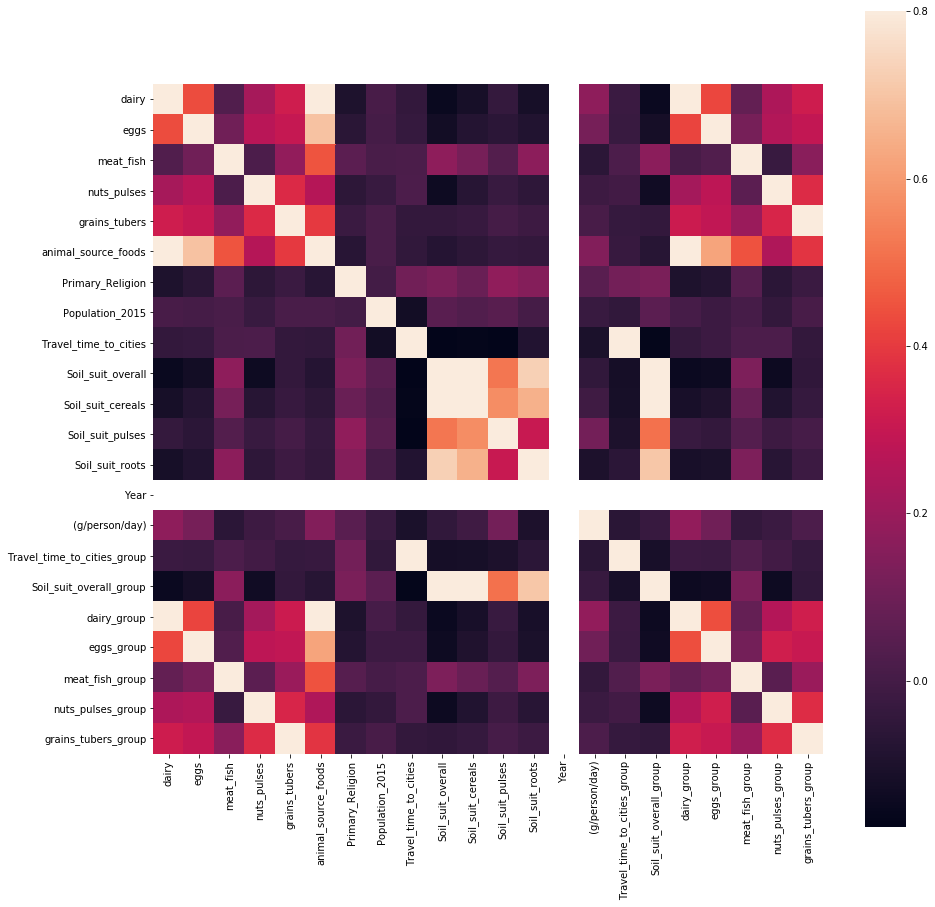

In [70]:
C_mat = cleaned_dhs_df.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)

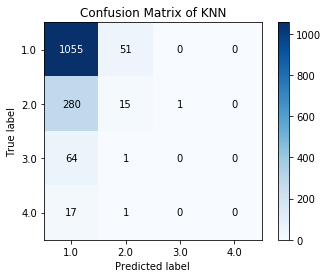

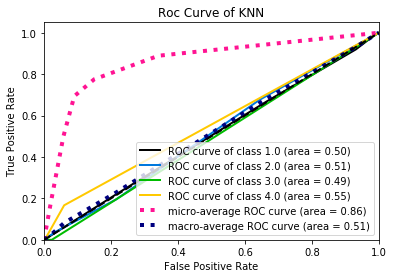

KNN Accuracy is 0.7205387205387206
KNN model's accuracy is 0.727317478712148, with a standard deviation of 0.018166609466923427


<Figure size 432x288 with 0 Axes>

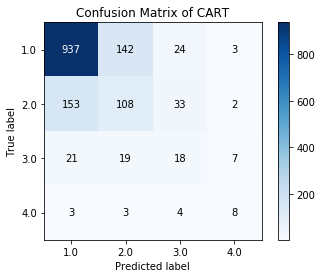

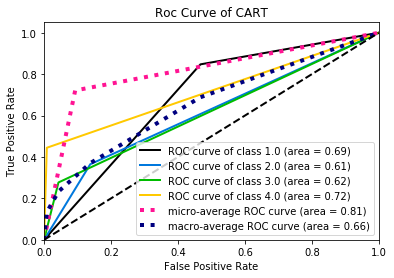

CART Accuracy is 0.7212121212121212
CART model's accuracy is 0.7349518818965083, with a standard deviation of 0.022296520616461705


<Figure size 432x288 with 0 Axes>

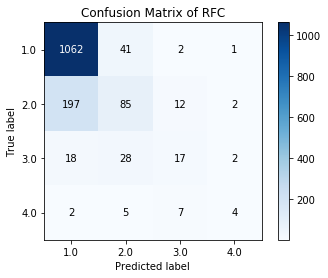

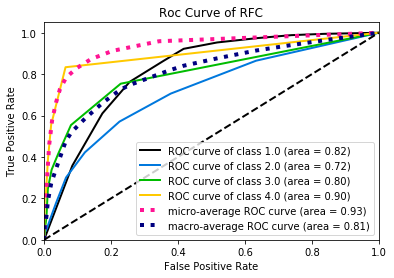

RFC Accuracy is 0.7865319865319865
RFC model's accuracy is 0.7861661712097547, with a standard deviation of 0.014513716521046984


<Figure size 432x288 with 0 Axes>

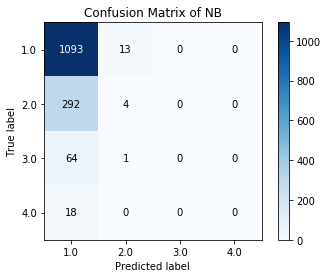

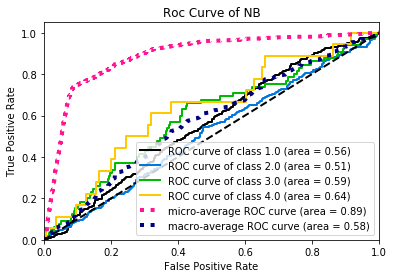

NB Accuracy is 0.7387205387205387
NB model's accuracy is 0.7475341361414822, with a standard deviation of 0.013909303777298291


<Figure size 432x288 with 0 Axes>

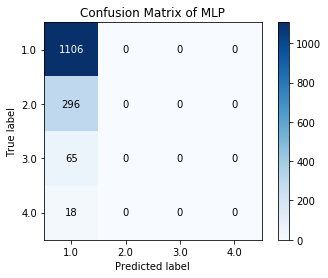

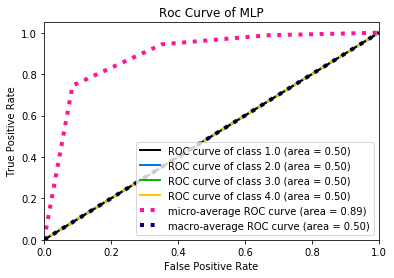

MLP Accuracy is 0.7447811447811448
MLP model's accuracy is 0.754046959238172, with a standard deviation of 0.015110640590179665


<Figure size 432x288 with 0 Axes>

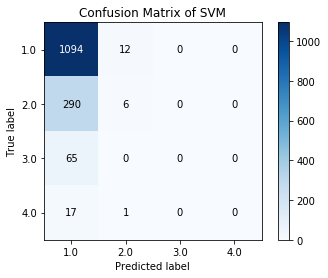

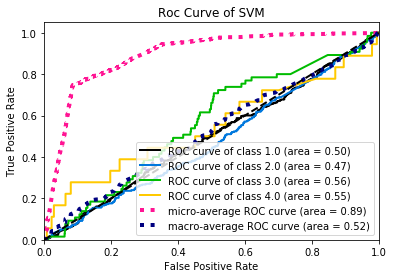

SVM Accuracy is 0.7407407407407407
SVM model's accuracy is 0.7470811709578274, with a standard deviation of 0.0146455945920335


<Figure size 432x288 with 0 Axes>

In [65]:
perform_ml(cleaned_dhs_egg_df)

In [15]:
cleaned_dhs_meat_fish_df = cleaned_dhs_df[desired_predictor_columns[:-1] + ["meat_fish_group"]]
perform_ml(cleaned_dhs_meat_fish_df)

NameError: name 'cleaned_dhs_df' is not defined

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/